In [6]:
import numpy as np
import sys
import os
import numpy as np
import matplotlib.pyplot as plt


GCMI_dir = '/home/laouen.belloli/Documents/git/Oinformation/benchmarking/libraries'
sys.path.append(GCMI_dir)

from gcmi.python import gcmi


def gaussian_entropy(covariance_matrix):
    n_variables = covariance_matrix.shape[0]
    cov_det = np.linalg.det(covariance_matrix) 
    return 0.5 * np.log((2 * np.pi * np.e)**n_variables * cov_det)


def o_information_gaussian(covariance_matrix):
    """
    Calculate the O-information for a Gaussian distribution given its mean and covariance matrix.

    Args:
        mean (np.ndarray): Mean vector of the Gaussian distribution.
        covariance_matrix (np.ndarray): Covariance matrix of the Gaussian distribution.

    Returns:
        float: Computed O-information for the Gaussian distribution.
    """

    N = covariance_matrix.shape[0]

    # H(X)
    system_entropy = gaussian_entropy(covariance_matrix)

    # H(X1), ..., H(Xn)
    individual_entropies = np.array([
        gaussian_entropy(np.array([[covariance_matrix[i, i]]])) for i in range(N)])

    # H(X-1), ..., H(X-n)
    single_exclusion_entropies = np.array([
        gaussian_entropy(np.delete(np.delete(covariance_matrix, i, axis=0), i, axis=1))
        for i in range(N)
    ])

    oinfo = (N - 2) * system_entropy + (individual_entropies - single_exclusion_entropies).sum()

    return (
        oinfo,
        system_entropy,
        individual_entropies,
        single_exclusion_entropies
    )


def gcmi_entropy(X:np.ndarray):
    return gcmi.ent_g(gcmi.copnorm(X.T)) * np.log(2)


def o_information(X: np.ndarray):

    N = X.shape[1]

    single_exclusions_mask = (np.ones((N, N)) - np.eye(N)).astype(bool)

    # H(X)
    system_entropy = gcmi_entropy(X)

    # H(X1), ..., H(Xn)
    individual_entropies = np.array([gcmi_entropy(X[:,[idx]]) for idx in range(N)])

    # H(X-1), ..., H(X-n)
    single_exclusion_entropies = np.array([gcmi_entropy(X[:,idxs]) for idxs in single_exclusions_mask])

    oinfo = (N - 2) * system_entropy + (individual_entropies - single_exclusion_entropies).sum()

    return (
        oinfo,
        system_entropy,
        individual_entropies,
        single_exclusion_entropies
    )


In [10]:
# Define the standard deviations
stds = np.linspace(10**-2, 10**2, 10, endpoint=True)

ests = []
reals = []
for std in stds:

    # Compute the variances (square of the standard deviations)
    variances = np.array([std for i in range(10)])**2

    # Create the diagonal covariance matrix with variances on the diagonal
    covariance_matrix = np.diag(variances)

    X = np.array([np.random.normal(0,std, 10000) for i in range(10)]).T

    ests.append(o_information(X))

    reals.append(o_information_gaussian(covariance_matrix))

In [27]:
relative_error_oinfo

array([94179318.5 ,         inf,         inf, 12975475.  ,         inf,
               inf,         inf,         inf, 44544560.25,         inf])

/tmp/ipykernel_175464/421583141.py:11: RuntimeWarning: divide by zero encountered in divide
  relative_error_oinfo = np.abs(est_oinfo - real_oinfo) / np.abs(real_oinfo)


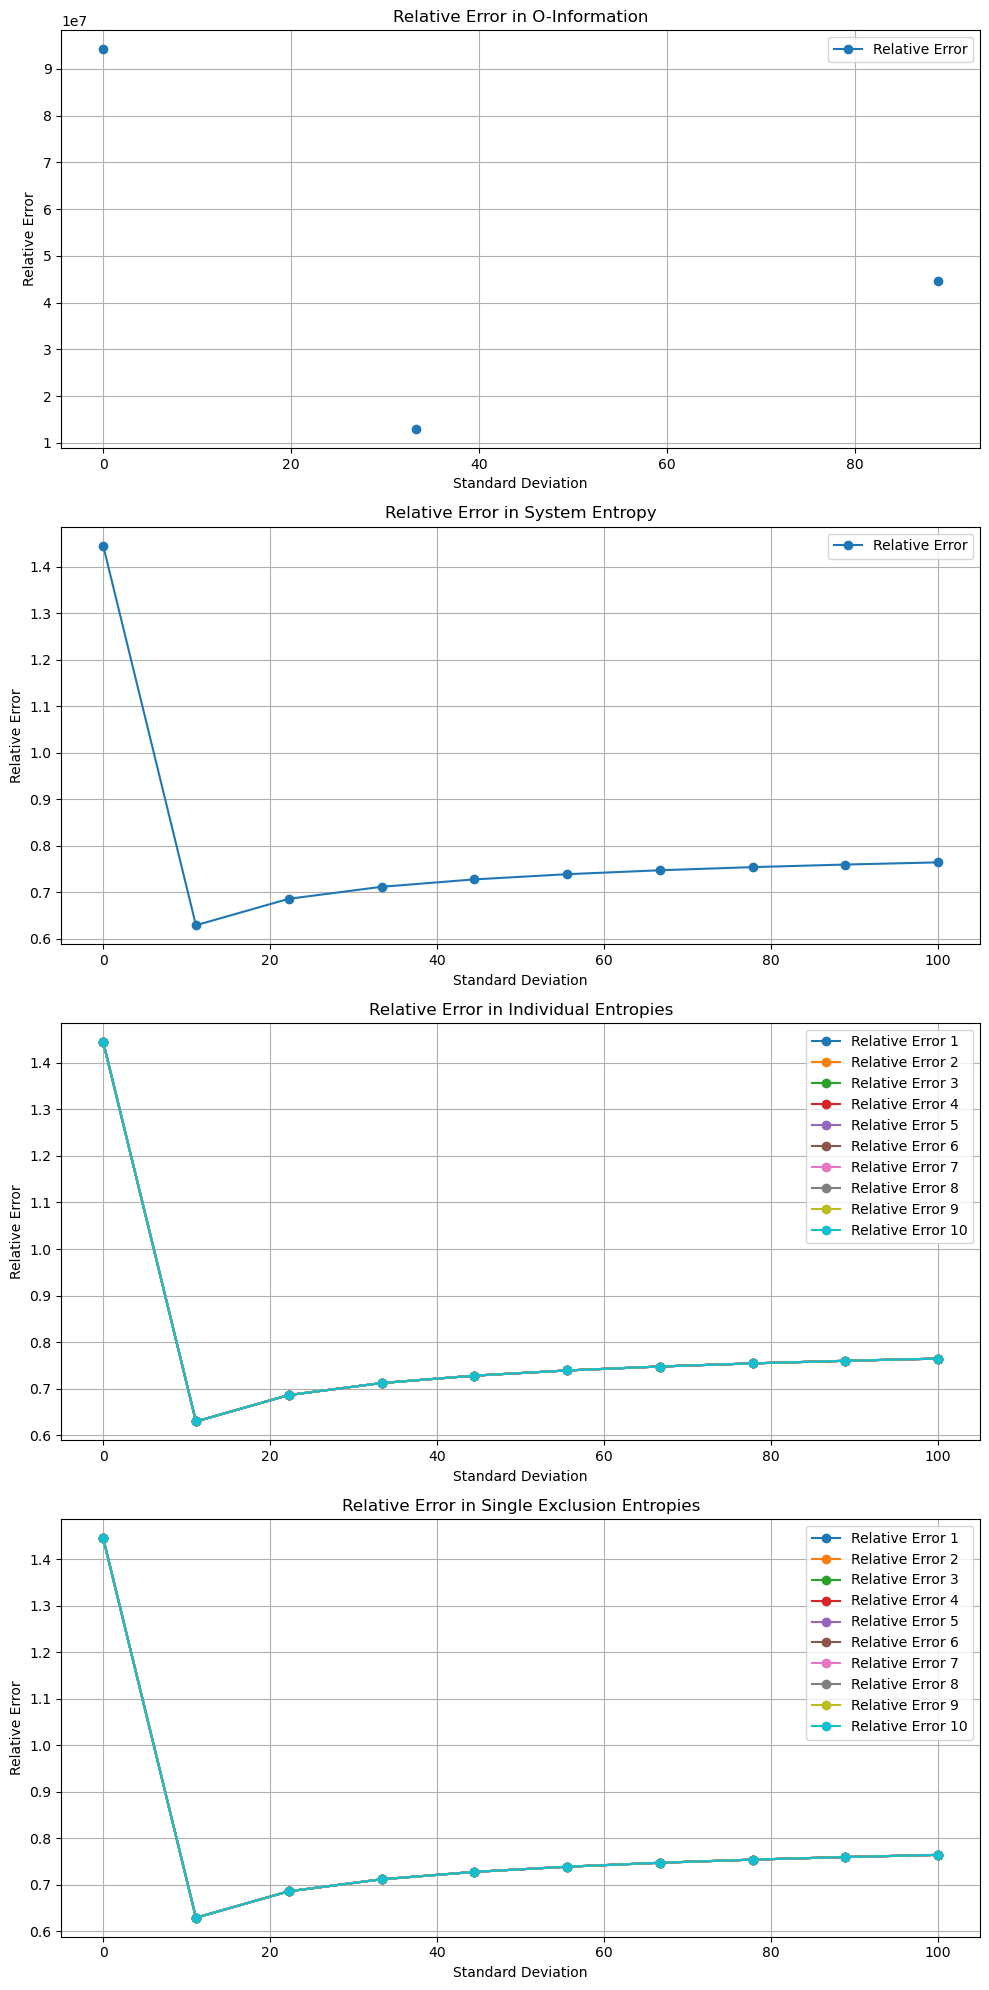

In [12]:
# Calculate the relative errors
est_oinfo, est_system_entropy, est_individual_entropies, est_single_exclusion_entropies = zip(*ests)
real_oinfo, real_system_entropy, real_individual_entropies, real_single_exclusion_entropies = zip(*reals)

# convert to numpy arrays
est_oinfo = np.array(est_oinfo)
est_system_entropy = np.array(est_system_entropy)
est_individual_entropies = np.array(est_individual_entropies)
est_single_exclusion_entropies = np.array(est_single_exclusion_entropies)

relative_error_oinfo = np.abs(est_oinfo - real_oinfo) / np.abs(real_oinfo)
relative_error_system_entropy = np.abs(est_system_entropy - real_system_entropy) / np.abs(real_system_entropy)
relative_error_individual_entropies = np.abs(est_individual_entropies - real_individual_entropies) / np.abs(real_individual_entropies)
relative_error_single_exclusion_entropies = np.abs(est_single_exclusion_entropies - real_single_exclusion_entropies) / np.abs(real_single_exclusion_entropies)

# Plotting the relative errors
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# O-Information
axs[0].plot(stds, relative_error_oinfo, 'o-', label='Relative Error')
axs[0].set_title('Relative Error in O-Information')
axs[0].set_xlabel('Standard Deviation')
axs[0].set_ylabel('Relative Error')
axs[0].legend()
axs[0].grid(True)

# System Entropy
axs[1].plot(stds, relative_error_system_entropy, 'o-', label='Relative Error')
axs[1].set_title('Relative Error in System Entropy')
axs[1].set_xlabel('Standard Deviation')
axs[1].set_ylabel('Relative Error')
axs[1].legend()
axs[1].grid(True)

# Individual Entropies
for i in range(relative_error_individual_entropies.shape[1]):
    axs[2].plot(stds, relative_error_individual_entropies[:, i], 'o-', label=f'Relative Error {i+1}')
axs[2].set_title('Relative Error in Individual Entropies')
axs[2].set_xlabel('Standard Deviation')
axs[2].set_ylabel('Relative Error')
axs[2].legend()
axs[2].grid(True)

# Single Exclusion Entropies
for i in range(relative_error_single_exclusion_entropies.shape[1]):
    axs[3].plot(stds, relative_error_single_exclusion_entropies[:, i], 'o-', label=f'Relative Error {i+1}')
axs[3].set_title('Relative Error in Single Exclusion Entropies')
axs[3].set_xlabel('Standard Deviation')
axs[3].set_ylabel('Relative Error')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()